In [1]:
import numpy as np
import torch

from tqdm.auto import tqdm
from tqdm.notebook import tqdm_notebook, trange

import itertools
import os
from dotenv import find_dotenv, load_dotenv
from pathlib import Path

load_dotenv(find_dotenv(), verbose=True)

True

# prepare data

In [2]:
from src.utils.ensemble import optimize_val_correlation
from src.config.config import combine_cfgs, get_cfg_defaults
from src.data.datamodule import MyDataModule

In [3]:
# prepare validation data
cfg = combine_cfgs('../src/config/experiments/algonauts2021_i3d_flow.yml')
dm = MyDataModule(cfg)
dm.prepare_data()
dm.setup()

val_indices = dm.val_dataset.indices

cache_path = Path('/data_smr/huze/.cache/val_fmris.pt')

if cache_path.exists():
    val_fmris = torch.load(cache_path)
else:
    val_fmris = [dm.dataset_train_val.__getitem__(i)[1] for i in tqdm(val_indices)]
    val_fmris = np.stack(val_fmris, 0)
    val_fmris = torch.tensor(val_fmris)
    torch.save(val_fmris, cache_path)

In [4]:
# load from notebook 900. (cross-notebook-ref)

In [5]:
import pandas as pd

In [6]:
submission_df = torch.load('./tmp/submission_df.pt')

In [7]:
submission_df

,model_sch,he_sch,roi_sch,cross_roi_sch,i_submission,path
0,multi_layer&i3d_rgb,H3,ROIxSMC,croi_ensemble,000,/data/huze/ray_results/algonauts2021/ensemble_...
1,single_layer&i3d_rgb+i3d_flow,H3,ROIxSC,croi_ensemble,001,/data/huze/ray_results/algonauts2021/ensemble_...
2,single_layer&i3d_rgb+i3d_flow,H3,ROI,,002,/data/huze/ray_results/algonauts2021/ensemble_...
3,single_layer&i3d_rgb+i3d_flow,H3,WB,,003,/data/huze/ray_results/algonauts2021/ensemble_...
4,single_layer&i3d_flow,H3,ROIxSMC,croi_ensemble,004,/data/huze/ray_results/algonauts2021/ensemble_...
5,single_layer&i3d_rgb+i3d_flow,H1,ROIxSMC,croi_ensemble,005,/data/huze/ray_results/algonauts2021/ensemble_...
6,single_layer&i3d_rgb+i3d_flow,H3,ROIxLC,croi_ensemble,006,/data/huze/ray_results/algonauts2021/ensemble_...
7,multi_layer&i3d_flow,H3,ROIxSMC,croi_ensemble,007,/data/huze/ray_results/algonauts2021/ensemble_...
8,single_layer&i3d_rgb+i3d_flow,H3,SMC,,008,/data/huze/ray_results/algonauts2021/ensemble_...
9,single_layer&i3d_rgb+i3d_flow,H2,ROIxSMC,croi_ensemble,009,/data/huze/ray_results/algonauts2021/ensemble_...


# validation score for each ROI and kROI

In [8]:
from src.utils.metrics import vectorized_correlation

In [9]:
rois = ['WB', 'V1', 'V2', 'V3', 'V4', 'LOC', 'EBA', 'FFA', 'STS', 'PPA', 'REST', 'SMC1', 'SMC2', 'MC2', 'MC1', 'SC3',
        'SC4', 'LC1',
        'LC2', 'LC3', 'LC4', 'LC5']

In [10]:
# validation set score

score_res_dicts = []

for i_row, row in tqdm(list(submission_df.iterrows())):
    # model_sch = row.model_sch
    # he_sch = row.he_sch
    # roi_sch = row.roi_sch

    path = row.path
    prediction = torch.load(path)
    scores = vectorized_correlation(prediction[val_indices], val_fmris)
    res_dict = {}
    for roi in rois:
        voxel_indices = torch.load(os.path.join(cfg.DATASET.VOXEL_INDEX_DIR, f'{roi}.pt'))
        score = scores[voxel_indices].mean().item()
        key = f'{roi}_val_score'
        res_dict[key] = f'{score:.4f}'
    score_res_dicts.append(res_dict)
roi_val_score_df = pd.DataFrame(score_res_dicts)

  0%|          | 0/22 [00:00<?, ?it/s]

In [11]:
all_score_df = submission_df.join(roi_val_score_df)

# whole brain submission score

In [12]:
# test set score

In [13]:
from io import StringIO

In [14]:
results = """NUM\tSCORE\tFILENAME\tSUBMISSION\tDATE\tSTATUS\t
91	0.3726401715	i=000,he_sch=H3,model_sch=multi_layer&i3d_rgb,roi_sch=ROIxSMC,cross_roi_sch=croi_ensemble_full_track.zip	02/28/2022 14:03:28	Finished		
92	0.3822759446	i=001,he_sch=H3,model_sch=single_layer&i3d_rgb+i3d_flow,roi_sch=ROIxSC,cross_roi_sch=croi_ensemble_full_track.zip	02/28/2022 14:04:23	Finished		
93	0.3658464045	i=002,he_sch=H3,model_sch=single_layer&i3d_rgb+i3d_flow,roi_sch=ROI_full_track.zip	02/28/2022 14:06:27	Finished		
94	0.3566607576	i=003,he_sch=H3,model_sch=single_layer&i3d_rgb+i3d_flow,roi_sch=WB_full_track.zip	02/28/2022 14:08:08	Finished		
95	0.3371816907	i=004,he_sch=H3,model_sch=single_layer&i3d_flow,roi_sch=ROIxSMC,cross_roi_sch=croi_ensemble_full_track.zip	02/28/2022 14:17:15	Finished		
96	0.3755210745	i=005,he_sch=H1,model_sch=single_layer&i3d_rgb+i3d_flow,roi_sch=ROIxSMC,cross_roi_sch=croi_ensemble_full_track.zip	02/28/2022 14:20:31	Finished		
97	0.3765596377	i=006,he_sch=H3,model_sch=single_layer&i3d_rgb+i3d_flow,roi_sch=ROIxLC,cross_roi_sch=croi_ensemble_full_track.zip	02/28/2022 14:21:09	Finished		
98	0.3409911341	i=007,he_sch=H3,model_sch=multi_layer&i3d_flow,roi_sch=ROIxSMC,cross_roi_sch=croi_ensemble_full_track.zip	02/28/2022 14:23:47	Finished		
99	0.3777393409	i=008,he_sch=H3,model_sch=single_layer&i3d_rgb+i3d_flow,roi_sch=SMC_full_track.zip	02/28/2022 14:24:18	Finished		
100	0.3782319207	i=009,he_sch=H2,model_sch=single_layer&i3d_rgb+i3d_flow,roi_sch=ROIxSMC,cross_roi_sch=croi_ensemble_full_track.zip	02/28/2022 14:25:02	Finished		
101	0.3780098575	i=010,he_sch=H3,model_sch=single_layer&i3d_rgb+i3d_flow,roi_sch=ROIxSMC,cross_roi_sch=voxel_swap_full_track.zip	02/28/2022 14:26:42	Finished		
102	0.3823800812	i=011,he_sch=H3,model_sch=single_layer+multi_layer&i3d_rgb+i3d_flow,roi_sch=ROIxSMC,cross_roi_sch=croi_ensemble_full_track.zip	02/28/2022 14:28:01	Finished		
103	0.3386854364	i=012,he_sch=H3,model_sch=single_layer+multi_layer&i3d_flow,roi_sch=ROIxSMC,cross_roi_sch=croi_ensemble_full_track.zip	02/28/2022 14:28:31	Finished		
104	0.3780980566	i=013,he_sch=H3,model_sch=single_layer+multi_layer&i3d_rgb,roi_sch=ROIxSMC,cross_roi_sch=croi_ensemble_full_track.zip	02/28/2022 14:29:19	Finished		
105	0.3823963473	i=014,he_sch=H3,model_sch=single_layer&i3d_rgb+i3d_flow,roi_sch=ROIxSMC,cross_roi_sch=croi_ensemble_full_track.zip	02/28/2022 14:30:10	Finished		
106	0.3792904924	i=015,he_sch=H3,model_sch=single_layer&i3d_rgb+i3d_flow,roi_sch=ROIxMC,cross_roi_sch=croi_ensemble_full_track.zip	02/28/2022 14:30:54	Finished		
107	0.3779275382	i=016,he_sch=H3,model_sch=single_layer&i3d_rgb,roi_sch=ROIxSMC,cross_roi_sch=croi_ensemble_full_track.zip	02/28/2022 14:31:34	Finished		
108	0.3820716002	i=017,he_sch=H3,model_sch=single_layer&i3d_rgb+i3d_flow,roi_sch=ROIxSMC,cross_roi_sch=croi_swap_full_track.zip	02/28/2022 14:32:14	Finished		
109	0.3710070445	i=018,he_sch=H3,model_sch=single_layer&i3d_rgb+i3d_flow,roi_sch=LC_full_track.zip	02/28/2022 14:33:03	Finished		
110	0.3778493967	i=019,he_sch=H3,model_sch=single_layer&i3d_rgb+i3d_flow,roi_sch=SC_full_track.zip	02/28/2022 14:33:56	Finished		
111	0.3747412699	i=020,he_sch=H3,model_sch=single_layer&i3d_rgb+i3d_flow,roi_sch=MC_full_track.zip	02/28/2022 14:34:33	Finished		
112	0.3771323259	i=021,he_sch=H3,model_sch=multi_layer&i3d_rgb+i3d_flow,roi_sch=ROIxSMC,cross_roi_sch=croi_ensemble_full_track.zip	02/28/2022 14:36:07	Finished	
"""

In [15]:
df = pd.read_csv(StringIO(results), sep="\t")

df['WB_test_score'] = df['SCORE'].apply(lambda x: f'{x:.4f}')

df = df[['WB_test_score']]

In [16]:
all_score_df = all_score_df.drop(columns=['WB_test_score'], errors='ignore')

In [17]:
all_score_df = all_score_df.join(df)

# ROI submission score

In [18]:
submission_output_dir = './submission_outputs'

In [19]:
# test set score
import zipfile

score_res_dicts = []

for i in range(1, len(all_score_df) + 1):
    # make sure the first file is `output_file (1).zip`
    with zipfile.ZipFile(os.path.join(submission_output_dir, f'output_file ({i}).zip'), 'r') as zip_ref:
        zip_ref.extractall(submission_output_dir)
    df = pd.read_csv(os.path.join(submission_output_dir, 'scores.txt'), sep=': ', header=None, engine='python')

    res_dict = {}
    for j in range(len(df)):
        roi, score = df.iloc[j]
        if roi == 'score': continue
        key = f'{roi}_test_score'
        res_dict[key] = f'{score:.4f}'
    score_res_dicts.append(res_dict)

roi_test_score_df = pd.DataFrame(score_res_dicts)

In [20]:
all_score_df = all_score_df.drop(columns=list(roi_test_score_df.keys()), errors='ignore')

In [21]:
all_score_df = all_score_df.join(roi_test_score_df)

# preprocess table

In [22]:
print(rois)

['WB', 'V1', 'V2', 'V3', 'V4', 'LOC', 'EBA', 'FFA', 'STS', 'PPA', 'REST', 'SMC1', 'SMC2', 'MC2', 'MC1', 'SC3', 'SC4', 'LC1', 'LC2', 'LC3', 'LC4', 'LC5']


In [23]:
for roi in rois:
    val_key = f'{roi}_val_score'
    test_key = f'{roi}_test_score'
    if test_key in all_score_df.keys():
        all_score_df[roi] = all_score_df[val_key] + '/' + all_score_df[test_key]
    else:
        all_score_df[roi] = all_score_df[val_key] + '/' + '-'

In [24]:
all_score_df.keys()

Index(['model_sch', 'he_sch', 'roi_sch', 'cross_roi_sch', 'i_submission',
       'path', 'WB_val_score', 'V1_val_score', 'V2_val_score', 'V3_val_score',
       'V4_val_score', 'LOC_val_score', 'EBA_val_score', 'FFA_val_score',
       'STS_val_score', 'PPA_val_score', 'REST_val_score', 'SMC1_val_score',
       'SMC2_val_score', 'MC2_val_score', 'MC1_val_score', 'SC3_val_score',
       'SC4_val_score', 'LC1_val_score', 'LC2_val_score', 'LC3_val_score',
       'LC4_val_score', 'LC5_val_score', 'WB_test_score', 'V1_test_score',
       'V2_test_score', 'V3_test_score', 'V4_test_score', 'LOC_test_score',
       'EBA_test_score', 'FFA_test_score', 'STS_test_score', 'PPA_test_score',
       'WB', 'V1', 'V2', 'V3', 'V4', 'LOC', 'EBA', 'FFA', 'STS', 'PPA', 'REST',
       'SMC1', 'SMC2', 'MC2', 'MC1', 'SC3', 'SC4', 'LC1', 'LC2', 'LC3', 'LC4',
       'LC5'],
      dtype='object')

In [25]:
interesting_keys = ['model_sch', 'he_sch', 'roi_sch', 'cross_roi_sch'] + rois

In [26]:
interesting_keys += ['WB_val_score', 'V1_val_score', 'V2_val_score', 'V3_val_score',
       'V4_val_score', 'LOC_val_score', 'EBA_val_score', 'FFA_val_score',
       'STS_val_score', 'PPA_val_score', 'REST_val_score', 'SMC1_val_score',
       'SMC2_val_score', 'MC2_val_score', 'MC1_val_score', 'SC3_val_score',
       'SC4_val_score', 'LC1_val_score', 'LC2_val_score', 'LC3_val_score',
       'LC4_val_score', 'LC5_val_score', 'WB_test_score', 'V1_test_score',
       'V2_test_score', 'V3_test_score', 'V4_test_score', 'LOC_test_score',
       'EBA_test_score', 'FFA_test_score', 'STS_test_score', 'PPA_test_score']

In [27]:
full_table_df = all_score_df[interesting_keys]

In [28]:
full_table_df.fillna('', inplace=True)

/tmp/ipykernel_29902/1856657398.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_table_df.fillna('', inplace=True)


In [29]:
full_table_df.to_csv('./tmp/full_table_df.csv')

# make tables

In [30]:
full_table_df = pd.read_csv('./tmp/full_table_df.csv')

In [31]:
full_table_df.fillna('', inplace=True)

In [32]:
full_table_df

,Unnamed: 0,model_sch,he_sch,roi_sch,cross_roi_sch,WB,V1,V2,V3,V4,...,WB_test_score,V1_test_score,V2_test_score,V3_test_score,V4_test_score,LOC_test_score,EBA_test_score,FFA_test_score,STS_test_score,PPA_test_score
0,0,multi_layer&i3d_rgb,H3,ROIxSMC,croi_ensemble,0.1747/0.3726,0.3335/0.6768,0.3221/0.6889,0.3059/0.6795,0.2812/0.7183,...,0.3726,0.6768,0.6889,0.6795,0.7183,0.7179,0.7647,0.7852,0.5856,0.6042
1,1,single_layer&i3d_rgb+i3d_flow,H3,ROIxSC,croi_ensemble,0.1800/0.3823,0.3339/0.6621,0.3232/0.6818,0.3080/0.6792,0.2841/0.7226,...,0.3823,0.6621,0.6818,0.6792,0.7226,0.7272,0.7726,0.7839,0.5872,0.6112
2,2,single_layer&i3d_rgb+i3d_flow,H3,ROI,,0.1700/0.3658,0.3333/0.6613,0.3228/0.6826,0.3061/0.6760,0.2829/0.7227,...,0.3658,0.6613,0.6826,0.6760,0.7227,0.7247,0.7698,0.7857,0.5901,0.6100
3,3,single_layer&i3d_rgb+i3d_flow,H3,WB,,0.1602/0.3567,0.2302/0.4921,0.2409/0.5266,0.2510/0.5729,0.2329/0.6239,...,0.3567,0.4921,0.5266,0.5729,0.6239,0.6975,0.7368,0.7175,0.5475,0.5746
4,4,single_layer&i3d_flow,H3,ROIxSMC,croi_ensemble,0.1565/0.3372,0.2551/0.5321,0.2619/0.5802,0.2692/0.6023,0.2530/0.6422,...,0.3372,0.5321,0.5802,0.6023,0.6422,0.6609,0.7225,0.6823,0.5215,0.5010
5,5,single_layer&i3d_rgb+i3d_flow,H1,ROIxSMC,croi_ensemble,0.1829/0.3755,0.3354/0.6587,0.3248/0.6797,0.3109/0.6704,0.2877/0.7115,...,0.3755,0.6587,0.6797,0.6704,0.7115,0.7220,0.7703,0.7751,0.5778,0.5979
6,6,single_layer&i3d_rgb+i3d_flow,H3,ROIxLC,croi_ensemble,0.1778/0.3766,0.3334/0.6615,0.3230/0.6823,0.3079/0.6794,0.2834/0.7249,...,0.3766,0.6615,0.6823,0.6794,0.7249,0.7270,0.7724,0.7856,0.5903,0.6110
7,7,multi_layer&i3d_flow,H3,ROIxSMC,croi_ensemble,0.1508/0.3410,0.2600/0.5398,0.2682/0.5919,0.2725/0.6043,0.2504/0.6522,...,0.3410,0.5398,0.5919,0.6043,0.6522,0.6768,0.7247,0.7108,0.5177,0.5472
8,8,single_layer&i3d_rgb+i3d_flow,H3,SMC,,0.1775/0.3777,0.2998/0.5884,0.2983/0.6173,0.2927/0.6420,0.2596/0.6649,...,0.3777,0.5884,0.6173,0.6420,0.6649,0.7191,0.7642,0.7537,0.5750,0.5922
9,9,single_layer&i3d_rgb+i3d_flow,H2,ROIxSMC,croi_ensemble,0.1826/0.3782,0.3350/0.6629,0.3257/0.6832,0.3090/0.6800,0.2886/0.7191,...,0.3782,0.6629,0.6832,0.6800,0.7191,0.7249,0.7654,0.7815,0.5832,0.6155


In [33]:
# load from notebook 900. (cross-notebook-ref)
submission_configs_keys = ['model_sch', 'he_sch', 'roi_sch', 'cross_roi_sch']
table_configs = [
    [
        ('single_layer&i3d_rgb+i3d_flow', 'H3', 'WB', ''),
        ('single_layer&i3d_rgb+i3d_flow', 'H3', 'ROI', ''),
        ('single_layer&i3d_rgb+i3d_flow', 'H3', 'SMC', ''),
        ('single_layer&i3d_rgb+i3d_flow', 'H3', 'ROIxSMC', 'croi_ensemble'),
    ],
    [
        ('single_layer&i3d_rgb+i3d_flow', 'H3', 'LC', ''),
        ('single_layer&i3d_rgb+i3d_flow', 'H3', 'MC', ''),
        ('single_layer&i3d_rgb+i3d_flow', 'H3', 'SMC', ''),
        ('single_layer&i3d_rgb+i3d_flow', 'H3', 'SC', ''),
        ('single_layer&i3d_rgb+i3d_flow', 'H3', 'ROIxLC', 'croi_ensemble'),
        ('single_layer&i3d_rgb+i3d_flow', 'H3', 'ROIxMC', 'croi_ensemble'),
        ('single_layer&i3d_rgb+i3d_flow', 'H3', 'ROIxSMC', 'croi_ensemble'),
        ('single_layer&i3d_rgb+i3d_flow', 'H3', 'ROIxSC', 'croi_ensemble'),
    ],
    [
        ('single_layer&i3d_rgb+i3d_flow', 'H3', 'ROI', ''),
        ('single_layer&i3d_rgb+i3d_flow', 'H3', 'SMC', ''),
        ('single_layer&i3d_rgb+i3d_flow', 'H3', 'ROIxSMC', 'croi_ensemble'),
        ('single_layer&i3d_rgb+i3d_flow', 'H3', 'ROIxSMC', 'croi_swap'),
        ('single_layer&i3d_rgb+i3d_flow', 'H3', 'ROIxSMC', 'voxel_swap'),
    ],
    [
        ('single_layer&i3d_rgb+i3d_flow', 'H3', 'ROIxLC', 'croi_ensemble'),
        ('single_layer&i3d_rgb+i3d_flow', 'H3', 'ROIxMC', 'croi_ensemble'),
        ('single_layer&i3d_rgb+i3d_flow', 'H3', 'ROIxSMC', 'croi_ensemble'),
        ('single_layer&i3d_rgb+i3d_flow', 'H3', 'ROIxSC', 'croi_ensemble'),
    ],
    [
        ('single_layer&i3d_rgb+i3d_flow', 'H1', 'ROIxSMC', 'croi_ensemble'),
        ('single_layer&i3d_rgb+i3d_flow', 'H2', 'ROIxSMC', 'croi_ensemble'),
        ('single_layer&i3d_rgb+i3d_flow', 'H3', 'ROIxSMC', 'croi_ensemble'),
    ],
    [
        ('single_layer&i3d_rgb', 'H3', 'ROIxSMC', 'croi_ensemble'),
        ('single_layer&i3d_flow', 'H3', 'ROIxSMC', 'croi_ensemble'),
        ('single_layer&i3d_rgb+i3d_flow', 'H3', 'ROIxSMC', 'croi_ensemble'),
        ('multi_layer&i3d_rgb', 'H3', 'ROIxSMC', 'croi_ensemble'),
        ('multi_layer&i3d_flow', 'H3', 'ROIxSMC', 'croi_ensemble'),
        ('multi_layer&i3d_rgb+i3d_flow', 'H3', 'ROIxSMC', 'croi_ensemble'),
        ('single_layer+multi_layer&i3d_rgb', 'H3', 'ROIxSMC', 'croi_ensemble'),
        ('single_layer+multi_layer&i3d_flow', 'H3', 'ROIxSMC', 'croi_ensemble'),
        ('single_layer+multi_layer&i3d_rgb+i3d_flow', 'H3', 'ROIxSMC', 'croi_ensemble'),
    ]
]
# table_configs = torch.load('./tmp/table_configs.pt')

In [34]:
from src.utils.misc import my_query_df
from pprint import pprint

table_dfs = []

for i, table_config in enumerate(table_configs):
    dfs = []
    for config in table_config:
        config_dict = {k: v for k, v in zip(submission_configs_keys, config)}
        df = my_query_df(full_table_df, equal_dict=config_dict)
        dfs.append(df)
    table_df = pd.concat(dfs)
    print(len(table_df))
    display(table_df)
    table_df.to_csv(f'./tables/Table {i + 1:02d}.csv')
    table_dfs.append(table_df)

4


,Unnamed: 0,model_sch,he_sch,roi_sch,cross_roi_sch,WB,V1,V2,V3,V4,...,WB_test_score,V1_test_score,V2_test_score,V3_test_score,V4_test_score,LOC_test_score,EBA_test_score,FFA_test_score,STS_test_score,PPA_test_score
3,3,single_layer&i3d_rgb+i3d_flow,H3,WB,,0.1602/0.3567,0.2302/0.4921,0.2409/0.5266,0.2510/0.5729,0.2329/0.6239,...,0.3567,0.4921,0.5266,0.5729,0.6239,0.6975,0.7368,0.7175,0.5475,0.5746
2,2,single_layer&i3d_rgb+i3d_flow,H3,ROI,,0.1700/0.3658,0.3333/0.6613,0.3228/0.6826,0.3061/0.6760,0.2829/0.7227,...,0.3658,0.6613,0.6826,0.6760,0.7227,0.7247,0.7698,0.7857,0.5901,0.6100
8,8,single_layer&i3d_rgb+i3d_flow,H3,SMC,,0.1775/0.3777,0.2998/0.5884,0.2983/0.6173,0.2927/0.6420,0.2596/0.6649,...,0.3777,0.5884,0.6173,0.6420,0.6649,0.7191,0.7642,0.7537,0.5750,0.5922
14,14,single_layer&i3d_rgb+i3d_flow,H3,ROIxSMC,croi_ensemble,0.1798/0.3824,0.3339/0.6620,0.3232/0.6817,0.3078/0.6794,0.2838/0.7239,...,0.3824,0.6620,0.6817,0.6794,0.7239,0.7275,0.7726,0.7848,0.5872,0.6114


8


,Unnamed: 0,model_sch,he_sch,roi_sch,cross_roi_sch,WB,V1,V2,V3,V4,...,WB_test_score,V1_test_score,V2_test_score,V3_test_score,V4_test_score,LOC_test_score,EBA_test_score,FFA_test_score,STS_test_score,PPA_test_score
18,18,single_layer&i3d_rgb+i3d_flow,H3,LC,,0.1754/0.3710,0.2963/0.5808,0.2943/0.6075,0.2885/0.6304,0.2568/0.6552,...,0.3710,0.5808,0.6075,0.6304,0.6552,0.7156,0.7596,0.7523,0.5695,0.5884
20,20,single_layer&i3d_rgb+i3d_flow,H3,MC,,0.1753/0.3747,0.2982/0.5910,0.2965/0.6167,0.2923/0.6408,0.2593/0.6642,...,0.3747,0.5910,0.6167,0.6408,0.6642,0.7186,0.7635,0.7548,0.5728,0.5908
8,8,single_layer&i3d_rgb+i3d_flow,H3,SMC,,0.1775/0.3777,0.2998/0.5884,0.2983/0.6173,0.2927/0.6420,0.2596/0.6649,...,0.3777,0.5884,0.6173,0.6420,0.6649,0.7191,0.7642,0.7537,0.5750,0.5922
19,19,single_layer&i3d_rgb+i3d_flow,H3,SC,,0.1778/0.3778,0.3010/0.5901,0.3003/0.6199,0.2938/0.6420,0.2608/0.6643,...,0.3778,0.5901,0.6199,0.6420,0.6643,0.7190,0.7651,0.7560,0.5788,0.5920
6,6,single_layer&i3d_rgb+i3d_flow,H3,ROIxLC,croi_ensemble,0.1778/0.3766,0.3334/0.6615,0.3230/0.6823,0.3079/0.6794,0.2834/0.7249,...,0.3766,0.6615,0.6823,0.6794,0.7249,0.7270,0.7724,0.7856,0.5903,0.6110
15,15,single_layer&i3d_rgb+i3d_flow,H3,ROIxMC,croi_ensemble,0.1775/0.3793,0.3335/0.6619,0.3231/0.6820,0.3078/0.6792,0.2837/0.7241,...,0.3793,0.6619,0.6820,0.6792,0.7241,0.7275,0.7730,0.7855,0.5858,0.6107
14,14,single_layer&i3d_rgb+i3d_flow,H3,ROIxSMC,croi_ensemble,0.1798/0.3824,0.3339/0.6620,0.3232/0.6817,0.3078/0.6794,0.2838/0.7239,...,0.3824,0.6620,0.6817,0.6794,0.7239,0.7275,0.7726,0.7848,0.5872,0.6114
1,1,single_layer&i3d_rgb+i3d_flow,H3,ROIxSC,croi_ensemble,0.1800/0.3823,0.3339/0.6621,0.3232/0.6818,0.3080/0.6792,0.2841/0.7226,...,0.3823,0.6621,0.6818,0.6792,0.7226,0.7272,0.7726,0.7839,0.5872,0.6112


5


,Unnamed: 0,model_sch,he_sch,roi_sch,cross_roi_sch,WB,V1,V2,V3,V4,...,WB_test_score,V1_test_score,V2_test_score,V3_test_score,V4_test_score,LOC_test_score,EBA_test_score,FFA_test_score,STS_test_score,PPA_test_score
2,2,single_layer&i3d_rgb+i3d_flow,H3,ROI,,0.1700/0.3658,0.3333/0.6613,0.3228/0.6826,0.3061/0.6760,0.2829/0.7227,...,0.3658,0.6613,0.6826,0.6760,0.7227,0.7247,0.7698,0.7857,0.5901,0.6100
8,8,single_layer&i3d_rgb+i3d_flow,H3,SMC,,0.1775/0.3777,0.2998/0.5884,0.2983/0.6173,0.2927/0.6420,0.2596/0.6649,...,0.3777,0.5884,0.6173,0.6420,0.6649,0.7191,0.7642,0.7537,0.5750,0.5922
14,14,single_layer&i3d_rgb+i3d_flow,H3,ROIxSMC,croi_ensemble,0.1798/0.3824,0.3339/0.6620,0.3232/0.6817,0.3078/0.6794,0.2838/0.7239,...,0.3824,0.6620,0.6817,0.6794,0.7239,0.7275,0.7726,0.7848,0.5872,0.6114
17,17,single_layer&i3d_rgb+i3d_flow,H3,ROIxSMC,croi_swap,0.1795/0.3821,0.3333/0.6613,0.3228/0.6826,0.3066/0.6783,0.2829/0.7227,...,0.3821,0.6613,0.6826,0.6783,0.7227,0.7258,0.7698,0.7857,0.5892,0.6101
10,10,single_layer&i3d_rgb+i3d_flow,H3,ROIxSMC,voxel_swap,0.1907/0.3780,0.3439/0.6539,0.3322/0.6724,0.3174/0.6708,0.2912/0.7112,...,0.3780,0.6539,0.6724,0.6708,0.7112,0.7255,0.7702,0.7788,0.5898,0.6039


4


,Unnamed: 0,model_sch,he_sch,roi_sch,cross_roi_sch,WB,V1,V2,V3,V4,...,WB_test_score,V1_test_score,V2_test_score,V3_test_score,V4_test_score,LOC_test_score,EBA_test_score,FFA_test_score,STS_test_score,PPA_test_score
6,6,single_layer&i3d_rgb+i3d_flow,H3,ROIxLC,croi_ensemble,0.1778/0.3766,0.3334/0.6615,0.3230/0.6823,0.3079/0.6794,0.2834/0.7249,...,0.3766,0.6615,0.6823,0.6794,0.7249,0.7270,0.7724,0.7856,0.5903,0.6110
15,15,single_layer&i3d_rgb+i3d_flow,H3,ROIxMC,croi_ensemble,0.1775/0.3793,0.3335/0.6619,0.3231/0.6820,0.3078/0.6792,0.2837/0.7241,...,0.3793,0.6619,0.6820,0.6792,0.7241,0.7275,0.7730,0.7855,0.5858,0.6107
14,14,single_layer&i3d_rgb+i3d_flow,H3,ROIxSMC,croi_ensemble,0.1798/0.3824,0.3339/0.6620,0.3232/0.6817,0.3078/0.6794,0.2838/0.7239,...,0.3824,0.6620,0.6817,0.6794,0.7239,0.7275,0.7726,0.7848,0.5872,0.6114
1,1,single_layer&i3d_rgb+i3d_flow,H3,ROIxSC,croi_ensemble,0.1800/0.3823,0.3339/0.6621,0.3232/0.6818,0.3080/0.6792,0.2841/0.7226,...,0.3823,0.6621,0.6818,0.6792,0.7226,0.7272,0.7726,0.7839,0.5872,0.6112


3


,Unnamed: 0,model_sch,he_sch,roi_sch,cross_roi_sch,WB,V1,V2,V3,V4,...,WB_test_score,V1_test_score,V2_test_score,V3_test_score,V4_test_score,LOC_test_score,EBA_test_score,FFA_test_score,STS_test_score,PPA_test_score
5,5,single_layer&i3d_rgb+i3d_flow,H1,ROIxSMC,croi_ensemble,0.1829/0.3755,0.3354/0.6587,0.3248/0.6797,0.3109/0.6704,0.2877/0.7115,...,0.3755,0.6587,0.6797,0.6704,0.7115,0.7220,0.7703,0.7751,0.5778,0.5979
9,9,single_layer&i3d_rgb+i3d_flow,H2,ROIxSMC,croi_ensemble,0.1826/0.3782,0.3350/0.6629,0.3257/0.6832,0.3090/0.6800,0.2886/0.7191,...,0.3782,0.6629,0.6832,0.6800,0.7191,0.7249,0.7654,0.7815,0.5832,0.6155
14,14,single_layer&i3d_rgb+i3d_flow,H3,ROIxSMC,croi_ensemble,0.1798/0.3824,0.3339/0.6620,0.3232/0.6817,0.3078/0.6794,0.2838/0.7239,...,0.3824,0.6620,0.6817,0.6794,0.7239,0.7275,0.7726,0.7848,0.5872,0.6114


9


,Unnamed: 0,model_sch,he_sch,roi_sch,cross_roi_sch,WB,V1,V2,V3,V4,...,WB_test_score,V1_test_score,V2_test_score,V3_test_score,V4_test_score,LOC_test_score,EBA_test_score,FFA_test_score,STS_test_score,PPA_test_score
16,16,single_layer&i3d_rgb,H3,ROIxSMC,croi_ensemble,0.1777/0.3779,0.3338/0.6605,0.3224/0.6795,0.3053/0.6753,0.2808/0.7183,...,0.3779,0.6605,0.6795,0.6753,0.7183,0.7210,0.7548,0.7872,0.5868,0.6099
4,4,single_layer&i3d_flow,H3,ROIxSMC,croi_ensemble,0.1565/0.3372,0.2551/0.5321,0.2619/0.5802,0.2692/0.6023,0.2530/0.6422,...,0.3372,0.5321,0.5802,0.6023,0.6422,0.6609,0.7225,0.6823,0.5215,0.5010
14,14,single_layer&i3d_rgb+i3d_flow,H3,ROIxSMC,croi_ensemble,0.1798/0.3824,0.3339/0.6620,0.3232/0.6817,0.3078/0.6794,0.2838/0.7239,...,0.3824,0.6620,0.6817,0.6794,0.7239,0.7275,0.7726,0.7848,0.5872,0.6114
0,0,multi_layer&i3d_rgb,H3,ROIxSMC,croi_ensemble,0.1747/0.3726,0.3335/0.6768,0.3221/0.6889,0.3059/0.6795,0.2812/0.7183,...,0.3726,0.6768,0.6889,0.6795,0.7183,0.7179,0.7647,0.7852,0.5856,0.6042
7,7,multi_layer&i3d_flow,H3,ROIxSMC,croi_ensemble,0.1508/0.3410,0.2600/0.5398,0.2682/0.5919,0.2725/0.6043,0.2504/0.6522,...,0.3410,0.5398,0.5919,0.6043,0.6522,0.6768,0.7247,0.7108,0.5177,0.5472
21,21,multi_layer&i3d_rgb+i3d_flow,H3,ROIxSMC,croi_ensemble,0.1764/0.3771,0.3343/0.6792,0.3234/0.6941,0.3091/0.6861,0.2845/0.7268,...,0.3771,0.6792,0.6941,0.6861,0.7268,0.7271,0.7753,0.7874,0.5857,0.6006
13,13,single_layer+multi_layer&i3d_rgb,H3,ROIxSMC,croi_ensemble,0.1788/0.3781,0.3375/0.6786,0.3256/0.6929,0.3087/0.6834,0.2840/0.7217,...,0.3781,0.6786,0.6929,0.6834,0.7217,0.7161,0.7576,0.7862,0.5871,0.5994
12,12,single_layer+multi_layer&i3d_flow,H3,ROIxSMC,croi_ensemble,0.1577/0.3387,0.2635/0.5446,0.2697/0.5942,0.2746/0.6106,0.2547/0.6489,...,0.3387,0.5446,0.5942,0.6106,0.6489,0.6682,0.7249,0.6988,0.5280,0.4951
11,11,single_layer+multi_layer&i3d_rgb+i3d_flow,H3,ROIxSMC,croi_ensemble,0.1809/0.3824,0.3383/0.6802,0.3263/0.6945,0.3107/0.6885,0.2871/0.7287,...,0.3824,0.6802,0.6945,0.6885,0.7287,0.7253,0.7706,0.7875,0.5864,0.6017


# bar plot of first table

In [35]:
table_df = table_dfs[0]

In [36]:
table_df

,Unnamed: 0,model_sch,he_sch,roi_sch,cross_roi_sch,WB,V1,V2,V3,V4,...,WB_test_score,V1_test_score,V2_test_score,V3_test_score,V4_test_score,LOC_test_score,EBA_test_score,FFA_test_score,STS_test_score,PPA_test_score
3,3,single_layer&i3d_rgb+i3d_flow,H3,WB,,0.1602/0.3567,0.2302/0.4921,0.2409/0.5266,0.2510/0.5729,0.2329/0.6239,...,0.3567,0.4921,0.5266,0.5729,0.6239,0.6975,0.7368,0.7175,0.5475,0.5746
2,2,single_layer&i3d_rgb+i3d_flow,H3,ROI,,0.1700/0.3658,0.3333/0.6613,0.3228/0.6826,0.3061/0.6760,0.2829/0.7227,...,0.3658,0.6613,0.6826,0.6760,0.7227,0.7247,0.7698,0.7857,0.5901,0.6100
8,8,single_layer&i3d_rgb+i3d_flow,H3,SMC,,0.1775/0.3777,0.2998/0.5884,0.2983/0.6173,0.2927/0.6420,0.2596/0.6649,...,0.3777,0.5884,0.6173,0.6420,0.6649,0.7191,0.7642,0.7537,0.5750,0.5922
14,14,single_layer&i3d_rgb+i3d_flow,H3,ROIxSMC,croi_ensemble,0.1798/0.3824,0.3339/0.6620,0.3232/0.6817,0.3078/0.6794,0.2838/0.7239,...,0.3824,0.6620,0.6817,0.6794,0.7239,0.7275,0.7726,0.7848,0.5872,0.6114


In [37]:
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

In [38]:
table_df = table_df[::-1]

In [39]:
validation_rois = ['WB',
 'V1',
 'V2',
 'V3',
 'V4',
 'LOC',
 'EBA',
 'FFA',
 'STS',
 'PPA',
 'REST',
 'SMC1',
 'SMC2',
 'MC2',
 'LC2',
 'LC3',
 'LC4',
 'LC5']
validation_rois_name_map = {
    'MC2': 'SMC3',
    'LC2': 'SMC4',
    'LC3': 'SMC5',
    'LC4': 'SMC6',
    'LC5': 'SMC7',
}
test_rois = ['WB',
 'V1',
 'V2',
 'V3',
 'V4',
 'LOC',
 'EBA',
 'FFA',
 'STS',
 'PPA',]

In [40]:
validation_plot_dicts = []
for i_row, row in table_df.iterrows():
    for roi in validation_rois:
        
        validation_plot_dicts.append({
            'roi_sch': row.roi_sch,
            'roi': roi if roi not in validation_rois_name_map.keys() else validation_rois_name_map[roi],
            'score': row[f'{roi}_val_score']
        })
validation_plot_df = pd.DataFrame(validation_plot_dicts)

In [41]:
validation_plot_df.head()

,roi_sch,roi,score
0,ROIxSMC,WB,0.1798
1,ROIxSMC,V1,0.3339
2,ROIxSMC,V2,0.3232
3,ROIxSMC,V3,0.3078
4,ROIxSMC,V4,0.2838


In [42]:
test_plot_dicts = []
for i_row, row in table_df.iterrows():
    for roi in test_rois:
        test_plot_dicts.append({
            'roi_sch': row.roi_sch,
            'roi': roi,
            'score': row[f'{roi}_test_score']
        })
test_plot_df = pd.DataFrame(test_plot_dicts)

In [43]:
test_plot_df.head()

,roi_sch,roi,score
0,ROIxSMC,WB,0.3824
1,ROIxSMC,V1,0.6620
2,ROIxSMC,V2,0.6817
3,ROIxSMC,V3,0.6794
4,ROIxSMC,V4,0.7239


In [44]:
from matplotlib.font_manager import FontProperties
import matplotlib

font = FontProperties()
# font.set_family('serif')
# font.set_name('Times New Roman')
font.set_style('italic')
font.set_size(26)

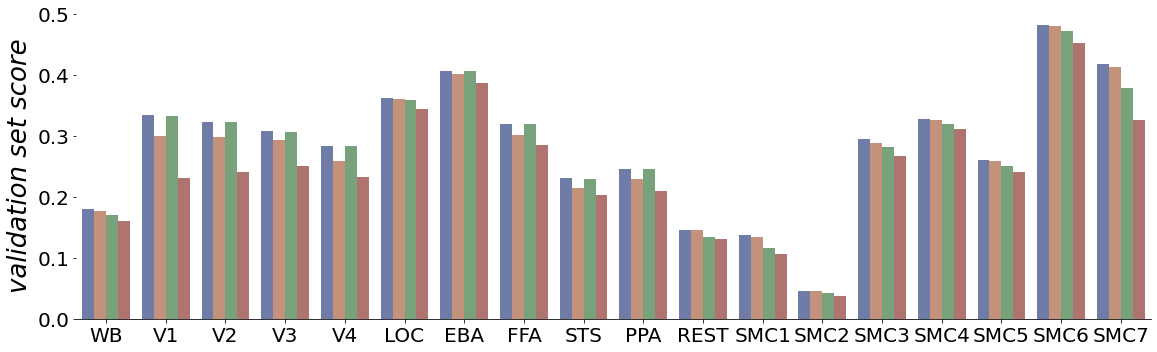

In [45]:
# fig, ax = plt.subplots(1, 1, figsize=(6, 6))
g = sns.catplot(
    data=validation_plot_df, kind="bar",
    x="roi", y="score", hue="roi_sch",
    ci="sd", palette="dark", alpha=.6, height=5,
    aspect=2/0.618, 
    legend=False,
    # legend_out=True,
)
g.despine(left=True)
g.set_axis_labels("", "validation set score", fontproperties=font)
# g.legend.set_title("Model", prop=font)
g.ax.tick_params(axis='both', which='major', labelsize=20)

# g.ax.legend(fontsize=20, title_fontsize='40')
# g.legend.remove()
plt.tight_layout()
plt.savefig('./figures/table 1 bar plot validation set.pdf', bbox_inches='tight')

In [46]:
import pylab as plot
params = {'legend.fontsize': 24,
          'legend.handlelength': 2}
plot.rcParams.update(params)

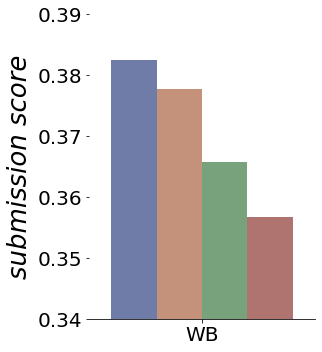

In [58]:
# fig, ax = plt.subplots(1, 1, figsize=(6, 6))
plot_df = test_plot_df[test_plot_df['roi'] == 'WB']
g = sns.catplot(
    data=plot_df, kind="bar",
    x="roi", y="score", hue="roi_sch",
    ci="sd", palette="dark", alpha=.6, height=5,
    aspect=0.5/0.618,
    legend_out=False,
    legend=False,
)
g.despine(left=True)
g.set_axis_labels("", "submission score", fontproperties=font)
# g.legend.set_title("Model ROI", prop=font)
g.ax.tick_params(axis='both', which='major', labelsize=20)

plt.ylim((0.34, 0.39))
plt.savefig('./figures/table 1 bar plot test set WB.pdf', bbox_inches='tight')

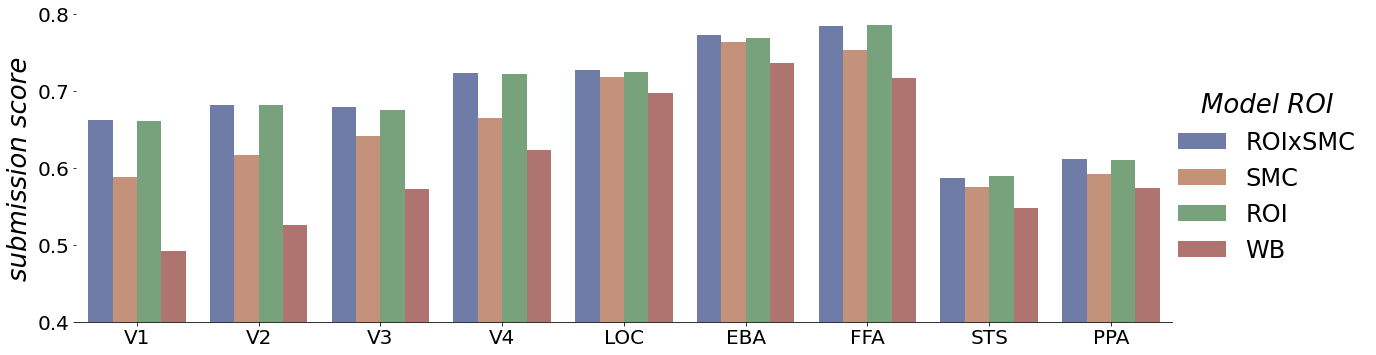

In [59]:
# fig, ax = plt.subplots(1, 1, figsize=(6, 6))
plot_df = test_plot_df[test_plot_df['roi'] != 'WB']
g = sns.catplot(
    data=plot_df, kind="bar",
    x="roi", y="score", hue="roi_sch",
    ci="sd", palette="dark", alpha=.6, height=5,
    aspect=2/0.618,
    legend_out=True,
)
g.despine(left=True)
g.set_axis_labels("", "submission score", fontproperties=font)
g.legend.set_title("Model ROI", prop=font)
g.ax.tick_params(axis='both', which='major', labelsize=20)

plt.ylim((0.4, 0.8))
plt.savefig('./figures/table 1 bar plot test set.pdf', bbox_inches='tight')